## Start with Imports and Loading in the Data

In [1]:
import gzip
import pandas as pd
import pandas_plink as pdpl
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import subprocess
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
!pip install plink

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Defaulting to user installation because normal site-packages is not writeable


In [2]:
# There are three file types for genetic data that interest us
# Multiple different samples of these files can be found on 1000 Genomes
# In the interest of size and reproducibility we will use just EUR.1 in the beginning
bim, fam, G = pdpl.read_plink("EUR.1.test/1000G.EUR.1")

# This file contains the gene expression data we will be using
gene_expr = pd.read_csv('GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz', compression='gzip', sep='\t')

# We also want to grab the gene annotations
with gzip.open("gene_annot.txt.gz", "rt") as f:
    # Read the file content into a pandas DataFrame
    gene_annotations = pd.read_csv(f, sep="\t")

Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]/home/jhauk/.local/lib/python3.9/site-packages/pandas_plink/_read.py:338: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = read_csv(
/home/jhauk/.local/lib/python3.9/site-packages/pandas_plink/_read.py:338: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = read_csv(
Mapping files: 100%|██████████| 3/3 [00:00<00:00, 25.49it/s]


## Data Wrangling

In [3]:
# We want to combine the files so that we have users as rows, and their snps as columns
geno_df = pd.DataFrame(G.compute().transpose())
geno_df.columns = bim['snp']  # Use SNP IDs as columns
geno_df.index = fam['iid']  # Use individual IDs as rows

# Transpose gene expression data so that individual IDs are in the index as well
gene_expr_t = gene_expr.set_index('Gene_Symbol').transpose()

# The data isn't always consistent across all the files, so we want to only pull data we have all the information for
# Extract the individual IDs that match those in fam['iid']
gene_expr_t.index.name = 'iid'
matching_ids = gene_expr_t.index.intersection(fam['iid'])

# Filter both dataframes to only include these matching IDs
geno_df_filtered = geno_df.loc[matching_ids]
gene_expr_filtered = gene_expr_t.loc[matching_ids]

## Test eQTL Analysis for a Single Gene

In [4]:
# Randomly select a gene to test:
gene_of_interest = 'ENSG00000152931.6'

# Adjust window according to gene location
# [We will automate this process in the next step]
snps_in_window = bim[(bim['chrom'] == "1") & 
                         (bim['pos'] >= 252566) & 
                         (bim['pos'] <= 1252566)]

# Get the SNP IDs from the filtered SNPs
snp_ids = snps_in_window['snp'].values

# Filter the genotype DataFrame for the SNPs in the window
genotype_data_window = geno_df.loc[:, snp_ids]

# Filter both dataframes to only include these matching IDs
geno_df_filtered = genotype_data_window.loc[matching_ids]
gene_expr_filtered = gene_expr_t.loc[matching_ids]

# Filter the gene expression data for the gene of interest
gene_expr_filtered = gene_expr_t.loc[matching_ids, gene_of_interest]

# Merge the gene expression data with genotype data
merged_df = pd.concat([gene_expr_filtered, geno_df_filtered], axis=1)

# Rename the gene expression column for clarity
merged_df.rename(columns={gene_of_interest: 'gene_expression'}, inplace=True)

# Ensure gene expression values are numeric
y = pd.to_numeric(merged_df['gene_expression'], errors='coerce')

# Iterate over each SNP column in the genotype data (independent variables)
results = {}
for snp in geno_df_filtered.columns:
    X = pd.to_numeric(merged_df[snp], errors='coerce')  # Convert SNP data to numeric
    X = sm.add_constant(X)  # Add an intercept for the linear regression
    
    # Drop rows with missing or invalid data (NaN)
    valid_data = pd.concat([y, X], axis=1).dropna()
    
    # Run the regression only if valid data exists
    if len(valid_data) > 0:
        model = sm.OLS(valid_data['gene_expression'], valid_data.iloc[:, 1:]).fit()  # Use .iloc to access predictors
        
        # Store the result for this SNP
        results[snp] = {
            'p-value': model.pvalues.iloc[1],  # Use .iloc to access the p-value for the SNP
            'beta': model.params.iloc[1],  # Use .iloc to access the beta coefficient for the SNP
            'r_squared': model.rsquared  # R-squared value
        }

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results).transpose()

# Sort by p-value to find significant eQTLs
significant_eqtls = results_df.sort_values('p-value').head()
print("Most Significant Results:")
print(significant_eqtls)
print("\nAll Results:")
print(results_df)

Most Significant Results:
            p-value      beta  r_squared
rs4970420  0.004872 -0.016493   0.022943
rs9442373  0.030045  0.010051   0.013688
rs3748594  0.038706 -0.023893   0.012437
rs3748593  0.052245 -0.022778   0.010973
rs6696281  0.071271 -0.017948   0.009482

All Results:
             p-value      beta  r_squared
rs3094315   0.179067 -0.008622   0.005273
rs3131972   0.150053 -0.009219   0.006048
rs3131969   0.365582 -0.006137   0.002394
rs1048488   0.208763 -0.007981   0.004616
rs3115850   0.223496 -0.007717   0.004330
...              ...       ...        ...
rs1536168   0.104462 -0.018155   0.007689
rs3737717   0.942082 -0.001428   0.000015
rs12103     0.541356 -0.003543   0.001092
rs12142199  0.302081 -0.005895   0.003114
rs34054191  0.759153 -0.003741   0.000275

[161 rows x 3 columns]


In [5]:
# adjust the results for plotting purposes
results_df['neg_log10_p'] = -np.log10(results_df['p-value'])
results_df1 = pd.merge(results_df, snps_in_window, left_index=True, right_on='snp')

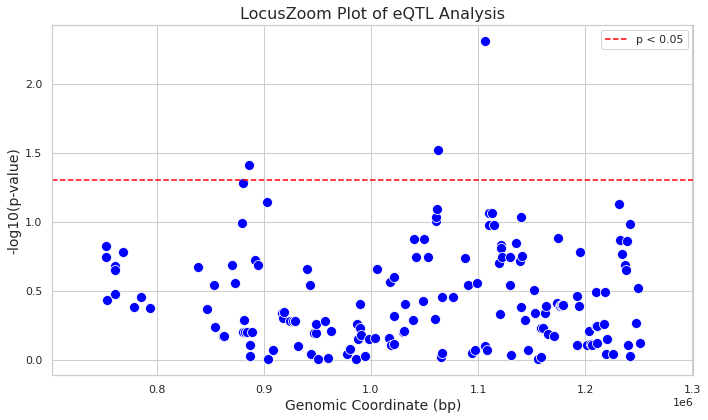

In [6]:
# Create a locus zoom plot to look at results
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df1, x='pos', y='neg_log10_p', color='blue', s=100)

# Adding labels and title
plt.title('LocusZoom Plot of eQTL Analysis', fontsize=16)
plt.xlabel('Genomic Coordinate (bp)', fontsize=14)
plt.ylabel('-log10(p-value)', fontsize=14)

# Adding a horizontal line for significance threshold (e.g., p < 0.05)
significance_threshold = -np.log10(0.05)
plt.axhline(y=significance_threshold, color='red', linestyle='--', label='p < 0.05')

# Customize x-axis limits (optional)
plt.xlim([results_df1['pos'].min() - 50000, results_df1['pos'].max() + 50000])

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Perform cis-eQTL for All the Genes on a Chromosome

In [51]:
# We will now repeat some of the process from above to transition to using chromosome 14
# This will help us in terms of size and time
bim, fam, G = pdpl.read_plink("EUR.14.test/1000G.EUR.14")

# This file contains the gene expression data we will be using
gene_expr = pd.read_csv('GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz', compression='gzip', sep='\t')

# We also want to grab the gene annotations
with gzip.open("gene_annot.txt.gz", "rt") as f:
    # Read the file content into a pandas DataFrame
    gene_annotations = pd.read_csv(f, sep="\t")
    
# We want to combine the files so that we have users as rows, and their snps as columns
geno_df = pd.DataFrame(G.compute().transpose())
geno_df.columns = bim['snp']  # Use SNP IDs as columns
geno_df.index = fam['iid']  # Use individual IDs as rows

# Transpose gene expression data so that individual IDs are in the index as well
gene_expr_t = gene_expr.set_index('Gene_Symbol').transpose()

# The data isn't always consistent across all the files, so we want to only pull data we have all the information for
# Extract the individual IDs that match those in fam['iid']
gene_expr_t.index.name = 'iid'
matching_ids = gene_expr_t.index.intersection(fam['iid'])

# Filter both dataframes to only include these matching IDs
geno_df_filtered = geno_df.loc[matching_ids]
gene_expr_filtered = gene_expr_t.loc[matching_ids]


Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]/home/jhauk/.local/lib/python3.9/site-packages/pandas_plink/_read.py:338: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = read_csv(
Mapping files: 100%|██████████| 3/3 [00:00<00:00, 48.29it/s]


In [54]:
# We will ramp up the process above, performing the analysis on a whole chromosome
# I have selected chromosome 14 for our test
chromosome = "14"
chr14_genes = gene_expr[gene_expr['Chr'] == chromosome]['Gene_Symbol']

# Initialize a list to store results for each SNP and gene as rows
chr14_results_list = []

for the_gene in chr4_genes:
    gene_info = gene_expr[gene_expr['Gene_Symbol'] == the_gene]
    snps_in_window = bim[(bim['chrom'] == chromosome) & 
                         (bim['pos'] >= int(gene_info['Coord'].iloc[0])-500000) & 
                         (bim['pos'] <= int(gene_info['Coord'].iloc[0])+500000)]
    
    # Get the SNP IDs from the filtered SNPs
    snp_ids = snps_in_window['snp'].values

    # Filter the genotype DataFrame for the SNPs in the window
    genotype_data_window = geno_df.loc[:, snp_ids]
    
    # Filter both dataframes to only include matching IDs
    geno_df_filtered = genotype_data_window.loc[matching_ids]
    gene_expr_filtered = gene_expr_t.loc[matching_ids]

    # Filter the gene expression data for the gene of interest
    gene_expr_filtered = gene_expr_t.loc[matching_ids, the_gene]

    # Merge the gene expression data with genotype data
    merged_df = pd.concat([gene_expr_filtered, geno_df_filtered], axis=1)

    # Rename the gene expression column for clarity
    merged_df.rename(columns={the_gene: 'gene_expression'}, inplace=True)
    
    # Ensure gene expression values are numeric
    y = pd.to_numeric(merged_df['gene_expression'], errors='coerce')

    for snp in geno_df_filtered.columns:
        X = pd.to_numeric(merged_df[snp], errors='coerce')  # Convert SNP data to numeric
        X = sm.add_constant(X)  # Add an intercept for the linear regression
    
        # Drop rows with missing or invalid data (NaN)
        valid_data = pd.concat([y, X], axis=1).dropna()
    
        # Run the regression only if valid data exists
        if len(valid_data) > 0:
            model = sm.OLS(valid_data['gene_expression'], valid_data.iloc[:, 1:]).fit()  # Use .iloc to access predictors

            if len(model.pvalues) > 1:
                # Append results for this SNP as a row in the results list
                chr4_results_list = chr14_results_list.append({
                    'Gene': the_gene,
                    'SNP': snp,
                    'p-value': model.pvalues.iloc[1],
                    'beta': model.params.iloc[1],
                    'r_squared': model.rsquared
                })
            else:
                print(f"Insufficient model output for SNP {snp}, skipping.")
                
    print(the_gene + ' completed')

# Convert the list of results into a DataFrame
chr14_results_df = pd.DataFrame(chr14_results_list)

ENSG00000243417.1 completed
ENSG00000152969.11 completed
ENSG00000249212.1 completed
ENSG00000251297.1 completed
ENSG00000248155.1 completed
ENSG00000178950.11 completed
ENSG00000145365.8 completed
ENSG00000164096.10 completed
ENSG00000186222.3 completed
ENSG00000248049.2 completed
ENSG00000164167.5 completed
ENSG00000168785.3 completed
ENSG00000225892.3 completed
ENSG00000249952.1 completed
ENSG00000197410.6 completed
ENSG00000251555.1 completed
ENSG00000248697.1 completed
ENSG00000152785.5 completed
ENSG00000151470.7 completed
ENSG00000241281.1 completed
ENSG00000185049.7 completed
ENSG00000250910.1 completed
ENSG00000223305.1 completed
ENSG00000109163.6 completed
ENSG00000213522.3 completed
ENSG00000151718.11 completed
ENSG00000061918.8 completed
ENSG00000186212.2 completed
ENSG00000182903.11 completed
ENSG00000251587.1 completed
ENSG00000157796.12 completed
ENSG00000236530.1 completed
ENSG00000087008.10 completed
ENSG00000248394.1 completed
ENSG00000213492.2 completed
ENSG000001632

Mapping files:   0%|          | 0/3 [01:46<?, ?it/s]


ENSG00000227725.2 completed
ENSG00000138722.5 completed
ENSG00000074966.6 completed
ENSG00000249934.1 completed
ENSG00000169020.5 completed
ENSG00000181359.5 completed
ENSG00000214980.4 completed
ENSG00000163257.6 completed
ENSG00000156234.7 completed
ENSG00000251432.2 completed
ENSG00000249844.1 completed
ENSG00000109775.6 completed
ENSG00000251259.1 completed
ENSG00000249244.1 completed
Insufficient model output for SNP rs1959807, skipping.
ENSG00000072201.8 completed
ENSG00000178458.4 completed
ENSG00000163743.9 completed
ENSG00000152795.12 completed
ENSG00000174607.6 completed
ENSG00000242358.1 completed
ENSG00000213434.2 completed
ENSG00000250131.1 completed
ENSG00000132405.14 completed
ENSG00000109436.7 completed
ENSG00000183432.6 completed
ENSG00000232327.3 completed
ENSG00000174125.3 completed
ENSG00000250413.1 completed
ENSG00000169989.2 completed
ENSG00000145349.12 completed
ENSG00000250980.1 completed
ENSG00000258013.1 completed
ENSG00000164031.12 completed
ENSG00000085871.4

ENSG00000213608.4 completed
ENSG00000248254.1 completed
ENSG00000249060.1 completed
ENSG00000127418.9 completed
ENSG00000154274.10 completed
ENSG00000251441.1 completed
ENSG00000178177.9 completed
ENSG00000163956.6 completed
ENSG00000132463.8 completed
ENSG00000169288.12 completed
ENSG00000087274.11 completed
ENSG00000138642.9 completed
ENSG00000109686.11 completed
ENSG00000237170.3 completed
ENSG00000163071.6 completed
ENSG00000137628.11 completed
ENSG00000168993.9 completed
ENSG00000249006.1 completed
ENSG00000236562.3 completed
ENSG00000164144.10 completed
ENSG00000171476.16 completed
ENSG00000179299.12 completed
ENSG00000244002.1 completed
ENSG00000123739.6 completed
ENSG00000249072.1 completed
ENSG00000170917.8 completed
Insufficient model output for SNP rs1959807, skipping.
ENSG00000249341.1 completed
ENSG00000170801.5 completed
ENSG00000162840.3 completed
ENSG00000205959.3 completed
ENSG00000249272.1 completed
ENSG00000249755.1 completed
ENSG00000251022.1 completed
ENSG000002496

ENSG00000121211.3 completed
ENSG00000198515.9 completed
ENSG00000164109.8 completed
ENSG00000240674.1 completed
ENSG00000260641.1 completed
ENSG00000109189.7 completed
ENSG00000163110.10 completed
ENSG00000250144.1 completed
ENSG00000145216.11 completed
ENSG00000109501.8 completed
ENSG00000131127.8 completed
ENSG00000138755.5 completed
ENSG00000198189.6 completed
ENSG00000109323.4 completed
ENSG00000196810.3 completed
ENSG00000227040.3 completed
ENSG00000241411.1 completed
ENSG00000174343.5 completed
ENSG00000234492.3 completed
ENSG00000151806.9 completed
ENSG00000159674.7 completed
ENSG00000243449.2 completed
ENSG00000129187.10 completed
ENSG00000168214.16 completed
ENSG00000249780.1 completed
ENSG00000246095.2 completed
ENSG00000118804.7 completed
ENSG00000138670.10 completed
ENSG00000246090.2 completed
ENSG00000164024.7 completed
ENSG00000260244.1 completed
ENSG00000138674.12 completed
ENSG00000251600.1 completed
ENSG00000129116.13 completed
ENSG00000138658.11 completed
ENSG00000251

In [70]:
chr14_results_df.to_csv('chr14_eqtl_data.txt', sep='\t', index=False)

In [94]:
chr14_results_df

,Gene,SNP,p-value,beta,r_squared
0,ENSG00000249212.1,rs2799784,0.480146,-0.002291,1.458764e-03
1,ENSG00000249212.1,rs1959919,0.812529,-0.000658,1.646931e-04
2,ENSG00000249212.1,rs8008487,0.072117,-0.004474,9.425716e-03
3,ENSG00000249212.1,rs1959918,0.812529,-0.000658,1.646931e-04
4,ENSG00000249212.1,rs1959928,0.012317,-0.009792,1.817704e-02
...,...,...,...,...,...
165509,ENSG00000243312.2,rs10148007,0.595599,0.011221,8.245056e-04
165510,ENSG00000243312.2,rs1349376,0.548497,0.012643,1.053664e-03
165511,ENSG00000243312.2,rs8006417,0.824377,-0.004875,1.442003e-04
165512,ENSG00000243312.2,rs8006648,0.995422,-0.000131,9.638331e-08


## Creating a PRS from the eQTL

In [168]:
# A potential clumping method starts by using plink:
'''
# Define the command as a list of strings
command = [
    "plink",
    "--bfile", "EUR.14.test${gene}",
    "--clump-p1", "0.0001",
    "--clump-r2", "0.1",
    "--clump-kb", "250",
    "--clump", "chr14_eqtl_data.txt",
    "--clump-snp-field", "SNP",
    "--clump-field", "P",
    "--out", "EUR.14.test_clumped"
]

# Run the PLINK command
subprocess.run(command)
'''

# Instead I will use a simpler approach:
threshold = 0.05
selected_snps = chr14_results_df[chr14_results_df['p-value'] <= threshold]
selected_snps_list = selected_snps['SNP'].tolist()

geno_selected = geno_df[selected_snps_list]

gene_id = 'ENSG00000165355.7' 
gene_expr_selected = gene_expr[gene_expr['Gene_Symbol'] == gene_id].set_index('Gene_Symbol').T

# Identify common sample IDs between the two datasets
common_samples = gene_expr_selected.index.intersection(geno_df.index)

# Subset both gene expression and genotype data to these common samples
gene_expr_selected = gene_expr_selected.loc[common_samples]
geno_selected = geno_df.loc[common_samples, selected_snps_list]  # Filter for significant SNPs

# Calculate PRS
prs_values = np.dot(geno_selected.values, selected_snps['beta'].values)

# Standardize PRS values and gene expression values
prs_scaler = StandardScaler()
gene_expr_scaler = StandardScaler()

prs_values_scaled = prs_scaler.fit_transform(prs_values.reshape(-1, 1))
gene_expr_scaled = gene_expr_scaler.fit_transform(gene_expr_selected.values)

# Fit linear regression
model = LinearRegression()
model.fit(prs_values_scaled, gene_expr_scaled)

# Predict and evaluate
predicted_expr_scaled = model.predict(prs_values_scaled)

# Calculate correlation and R-squared
correlation = np.corrcoef(predicted_expr_scaled.flatten(), gene_expr_scaled.flatten())[0,1]
r2 = r2_score(gene_expr_scaled, predicted_expr_scaled)

print("Correlation:", correlation)
print("R-squared:", r2)

Correlation: 0.04776757645646745
R-squared: 0.002281741360524614


In [169]:
# Not that I have tried one p-value I would like to test if other p-values may work better:
for threshold in [1, 0.05, 0.01, 0.001, 0.00001]:
    selected_snps = chr14_results_df[chr14_results_df['p-value'] <= threshold]
    selected_snps_list = selected_snps['SNP'].tolist()

    geno_selected = geno_df[selected_snps_list]

    gene_id = 'ENSG00000165355.7' 
    gene_expr_selected = gene_expr[gene_expr['Gene_Symbol'] == gene_id].set_index('Gene_Symbol').T

    # Identify common sample IDs between the two datasets
    common_samples = gene_expr_selected.index.intersection(geno_df.index)

    # Subset both gene expression and genotype data to these common samples
    gene_expr_selected = gene_expr_selected.loc[common_samples]
    geno_selected = geno_df.loc[common_samples, selected_snps_list]  # Filter for significant SNPs

    # Calculate PRS
    prs_values = np.dot(geno_selected.values, selected_snps['beta'].values)

    # Standardize PRS values and gene expression values
    prs_scaler = StandardScaler()
    gene_expr_scaler = StandardScaler()

    prs_values_scaled = prs_scaler.fit_transform(prs_values.reshape(-1, 1))
    gene_expr_scaled = gene_expr_scaler.fit_transform(gene_expr_selected.values)

    # Fit linear regression
    model = LinearRegression()
    model.fit(prs_values_scaled, gene_expr_scaled)

    # Predict and evaluate
    predicted_expr_scaled = model.predict(prs_values_scaled)

    # Calculate correlation and R-squared
    correlation = np.corrcoef(predicted_expr_scaled.flatten(), gene_expr_scaled.flatten())[0,1]
    r2 = r2_score(gene_expr_scaled, predicted_expr_scaled)

    print("Using threshold:", threshold)
    print("Correlation:", correlation)
    print("R-squared:", r2)
    print("")

Using threshold: 1
Correlation: 0.04701723549191625
R-squared: 0.002210620433302335

Using threshold: 0.05
Correlation: 0.04776757645646745
R-squared: 0.002281741360524614

Using threshold: 0.01
Correlation: 0.011403420193361961
R-squared: 0.00013003799210653533

Using threshold: 0.001
Correlation: 0.005541453223501891
R-squared: 3.070770382829213e-05

Using threshold: 1e-05
Correlation: 0.05436162121881777
R-squared: 0.00295518586153809

